In [1]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

Using TensorFlow backend.


In [2]:
DS = pd.read_csv("FR_Object_tagged_Subset_150SentenceLength.csv")

In [3]:
DS['tag'].fillna('text', inplace=True)

In [18]:
DS.loc[np.r_[7:11,15:18,20:21],:] 

text_ID         word     tag
7     51616       toonid    text
8     51616  rütmilised,    text
9     51616           fr  object
10    51616          72,  object
15   101498         rütm    text
16   101498           fr  object
17   101498           83  object
20   101498          ii,    text

In [4]:
words = list(set(DS["word"].values))
n_words = len(words)
tags = list(set(DS["tag"].values))
n_tags = len(tags)

In [5]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]
getter = SentenceGetter(DS)
sentences = getter.sentences


In [6]:
max_len = 150
max_len_char = 10

In [7]:
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [8]:
tag2idx

{'object': 1, 'text': 2, 'PAD': 0}

In [9]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)


100


In [10]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1 #For predictions
char2idx["PAD"] = 0

In [11]:
idx2char = {i: w for w, i in char2idx.items()}

In [12]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [13]:
y = [[tag2idx[w[1]] for w  in s] for s in sentences]


In [14]:
len(sentences)

4072

In [15]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [16]:
y[1]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
tag2idx

{'object': 1, 'text': 2, 'PAD': 0}

In [18]:
from sklearn.model_selection import train_test_split
X_char_tr, X_char_te, y_tr,  y_te= train_test_split(X_char, y, test_size=0.8, random_state=2018)


In [19]:
max_len_char

10

In [20]:
from keras.models import load_model
 
# load model
model = load_model('CharacterEmbeddingObject-1.00.hdf5')
# summarize model.
model.summary()

C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 10)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 10, 20)       2120      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 150, 20)           3280      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 20)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 40)           6560      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 150, 3)            123       
Total params: 12,083
Trainable params: 12,083
Non-trainable params: 0
_______________________________________________________

In [21]:
# model.layers[4:]

In [23]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop

# # Saving the best model only
# filepath="CharacterEmbeddingObject-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# for layer in model.layers[:4]:
#     layer.trainable = False
# for layer in model.layers[4:]:
#     layer.trainable = True

# early_stopping = EarlyStopping(monitor='val_acc', patience=5)
#https://www.depends-on-the-definition.com/transfer-learning-for-dog-breed-identification/

# model.compile(optimizer=Adam(lr=0.0001, momentum=0.9),
#               loss='sparse_categorical_crossentropy',
#               metrics=["acc"])

# Fit the best model
history = model.fit(np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)),
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)
#,callbacks=callbacks_list

Train on 732 samples, validate on 82 samples
Epoch 1/10
732/732 [==============================] - 6s 8ms/step - loss: 0.0313 - acc: 0.9909 - val_loss: 0.0249 - val_acc: 0.9922
Epoch 2/10
732/732 [==============================] - 5s 7ms/step - loss: 0.0257 - acc: 0.9920 - val_loss: 0.0240 - val_acc: 0.9924
Epoch 3/10
732/732 [==============================] - 5s 7ms/step - loss: 0.0228 - acc: 0.9922 - val_loss: 0.0198 - val_acc: 0.9926
Epoch 4/10
732/732 [==============================] - 5s 7ms/step - loss: 0.0190 - acc: 0.9933 - val_loss: 0.0155 - val_acc: 0.9952
Epoch 5/10
732/732 [==============================] - 5s 7ms/step - loss: 0.0165 - acc: 0.9944 - val_loss: 0.0130 - val_acc: 0.9956
Epoch 6/10
732/732 [==============================] - 5s 7ms/step - loss: 0.0142 - acc: 0.9952 - val_loss: 0.0110 - val_acc: 0.9968
Epoch 7/10
732/732 [==============================] - 5s 7ms/step - loss: 0.0119 - acc: 0.9960 - val_loss: 0.0085 - val_acc: 0.9977
Epoch 8/10
732/732 [===========

In [24]:
model.layers

In [25]:
hist = pd.DataFrame(history.history)


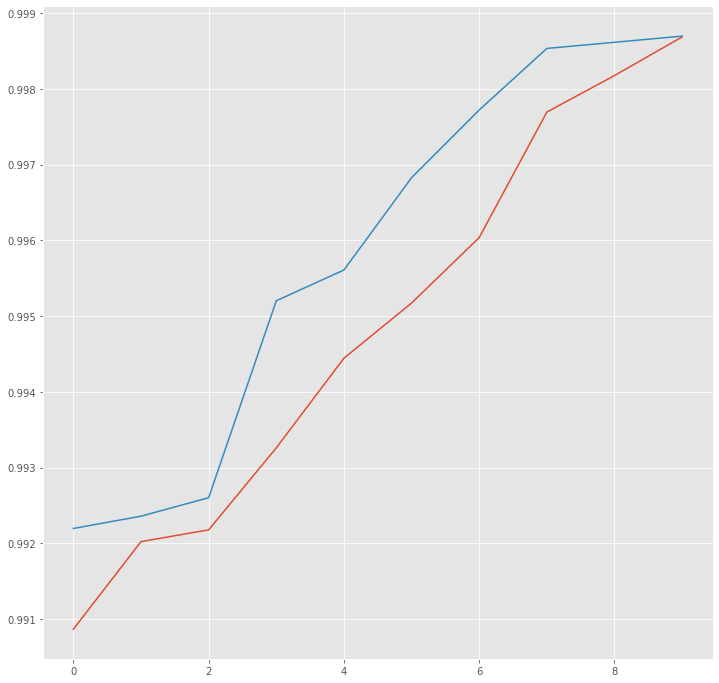

In [26]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()


In [27]:
def charindx2word(Tword):
    word = []
    for i in range(len(Tword)):
        if(Tword[i] !=0):
            word.append(idx2char[Tword[i]])
    return "".join(word)

In [28]:
y_pred = model.predict(
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char)))


In [29]:
len(np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char)))

3258

In [30]:
np.array(X_char_tr).reshape((len(X_char_tr),
                                                     max_len, max_len_char)).shape

(814, 150, 10)

In [31]:
i = 1
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_char_te[i], y_te[i], p):
    if t != 0: #PAD
        print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
EKG            : text  text
Holter:        : text  text
siinusrütm     : text  text
fr             : object object
63-127         : object object
xmin,          : text  text
keskmine       : text  text
sagedus        : text  text
83             : text  text
xmin.          : text  text
Rütmihäire     : text  text
Kokkuvõtva     : text  text
ravi           : text  text
ja             : text  text
plaanid        : text  text
jäävad         : text  text
samaks!        : text  text


In [32]:
len(y_pred)

3258

### Wrong Tags


In [33]:
j = 0
for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
#     print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
#     print(30 * "=")
    for w, t, pred in zip(X_char_te[i], y_te[i], p):
        if charindx2word(w) != "": #PAD
            if idx2tag[t] != idx2tag[pred]:
                print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))
                j = j+1


49             : text  object
mmHg,fr79x     : object text
fr78.Kl.ja     : object text
90',PQ         : object text
mmHg,fr        : object text
72             : object text
mmHg,fr69x     : object text
r              : text  object
133            : text  object
=              : text  object
63             : object text
Normofrekv     : object text
=              : text  object
76             : object text
66             : object text
120/80;fr      : object text
74;            : object text
64',St         : object text
=              : text  object
77             : object text
FA.fr          : object text
70/min.        : object text
EKG:fr67x'     : object text
=              : text  object
88             : object text
x/min,         : text  object
nefroloogi     : object text
Siinusrütm     : object text
76             : object text
Siinusrütm     : object text
76             : object text
Siinusrütm     : object text
76             : object text
200/100mmH     : object text
200/10

bradüarütm     : object text
58             : object text
bradüarütm     : object text
58             : object text
fr74x`,        : object text
mmHg,fr        : object text
56             : object text
EKG-normof     : object text
arütmia,fr     : object text
72,horizon     : object text
Siinusrütm     : object text
80/min.        : object text
fr73x1         : object text
=              : text  object
75             : object text
frekvents      : object text
frekvents      : object text
frekvents      : object text
siinusrütm     : object text
80             : object text
Siinusbrad     : object text
55/min.        : object text
x/min,         : text  object
Siinusrütm     : object text
60x'.          : object text
ekg-siinus     : object text
68x            : object text
fr61           : object PAD
nefrekoomi     : object text
130/85         : object text
64,            : text  object
416            : object text
416            : object text
416            : object text
416         

In [34]:
j

534

In [35]:
i = 1001
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_char_te[i], y_te[i], p):
    if t != 0: #PAD
        print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
05.09.2012     : text  text
-              : text  text
Parem.Süda     : text  text
puuduvad.      : text  text
Hommikuks      : text  text
RR             : text  text
kõrgem.        : text  text
Obj:           : text  text
RR             : text  text
165/60         : text  text
mmHg,          : text  text
fr             : object object
64x            : object object
regul,turs     : text  text
ei             : text  text
ole.           : text  text


In [36]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "text"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD", "text"))
        out.append(out_i)
    return out

pred_labels = pred2label(y_pred)
test_labels = test2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))


F1-score: 89.2%
           precision    recall  f1-score   support

     text       0.93      0.88      0.91      5198
   object       0.92      0.80      0.86      1992

micro avg       0.92      0.86      0.89      7190
macro avg       0.92      0.86      0.89      7190



In [37]:
accuracy_score(test_labels, pred_labels)

0.9989093513402906

In [38]:
from sklearn_crfsuite.metrics import flat_classification_report,flat_accuracy_score
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)
print("Accuracy",flat_accuracy_score(y_pred=pred_labels, y_true=test_labels))

              precision    recall  f1-score   support

      object       0.96      0.89      0.93      3707
        text       1.00      1.00      1.00    484993

    accuracy                           1.00    488700
   macro avg       0.98      0.95      0.96    488700
weighted avg       1.00      1.00      1.00    488700

Accuracy 0.9989093513402906


In [39]:
from sklearn_crfsuite.metrics import flat_f1_score, flat_precision_score, flat_recall_score

In [40]:
def pred2label2(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(p_i)
        out.append(out_i)
    return out
y_predNew = pred2label2(y_pred)
print(flat_recall_score(y_pred=np.array(y_predNew) , y_true= y_te ,average = "micro"))
print(flat_f1_score(y_pred=np.array(y_predNew),  y_true= y_te ,average = "micro"))
print(flat_precision_score(y_pred=np.array(y_predNew), y_true= y_te ,average = "micro"))


0.9989073050951504
0.9989073050951504
0.9989073050951504


In [ ]:
# from sklearn.metrics import precision_recall_fscore_support
# precision_recall_fscore_support(y_pred=pred_labels, y_true=test_labels)

In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix
# multilabel_confusion_matrix(y_pred=pred_labels, y_true=test_labels)
